# Тестовое задание

**Кандидат**: Антон Константинов ([antv.konstantinov@gmail.com](mailto:antv.konstantinov@gmail.com))

## Предварительный анализ

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 14

Загрузим данные.

In [147]:
df = pd.read_csv('data/train.csv')
y = df['y']

df_test = pd.read_csv('data/test.csv')

Зададим для целочисленных признаков правильные типы.

In [148]:
def numeric_downcast(col):
    try:
        new_col = pd.to_numeric(col, downcast='integer')
    except:
        new_col = col
    return new_col

df = df.apply(numeric_downcast)
df_test = df_test.apply(numeric_downcast)

Распределение меток классов не выглядит очень несбалансированным, поэтому искусственная балансировка классов скорее всего не потребуется.

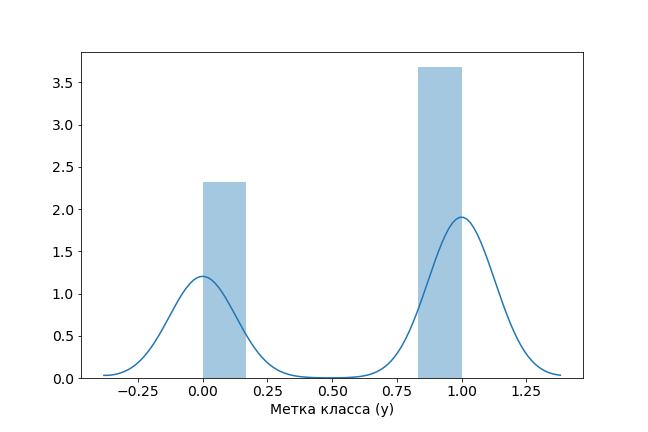

In [149]:
sns.distplot(y, axlabel='Метка класса (y)')

Посмотрим на пропуски в данных.

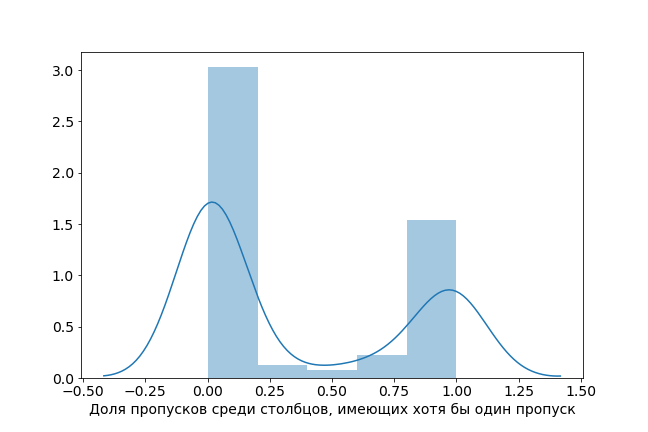

In [150]:
# Количество пропусков в столбцах
invalid = df.shape[0] - df.count()

# Выбросим столбцы без пропусков
missing = invalid[invalid > 0]

# В долях
missing_fraction = missing / df.shape[0]

# Ради наглядности построим гистограмму
sns.distplot(missing_fraction, axlabel='Доля пропусков среди столбцов, имеющих хотя бы один пропуск')

Наблюдается достаточно много столбцов с очень большим количеством пропусков. Выбросим столбцы, имеющие более 75% пропусков. Пропуски в остальных мы постараемся заполнить позже.

In [151]:
bad_columns = missing_fraction[missing_fraction > 0.75].index

df = df.drop(columns=bad_columns)
df_test = df_test.drop(columns=bad_columns)

Попробуем выделить среди признаков такие, которые скорее всего являются категориальными.

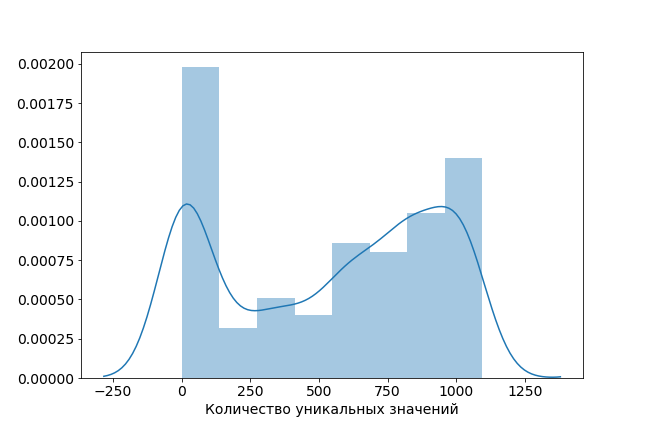

In [152]:
nunique = df.nunique()

sns.distplot(nunique, axlabel='Количество уникальных значений')

Выбросим признаки, имеющие единственное уникальное значение - они не несут совсем никакой смысловой нагрузки.

In [153]:
single_value_columns = nunique[nunique == 1].index

df = df.drop(columns=single_value_columns)
df_test = df_test.drop(columns=single_value_columns)

Наблюдается большое количество признаков, имеющих мало уникальных значений. Часть признаков, имеющих небольшое число уровней, скорее всего стоит интерпретировать как категориальные.

In [166]:
int8_cols = df.select_dtypes(include=['int8'])
unique_values = int8_cols.nunique()

possibly_categorical = unique_values[unique_values <= 15].index

Пока что выделим в качестве категориальных признаки, имеющие от 2 до 15 уникальных значений. В дальнейшем скорее всего потребуется применить к ним OneHot- или Target-кодирование.